In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from torch.nn.functional import conv2d, conv3d
from scipy.ndimage import convolve, generate_binary_structure
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

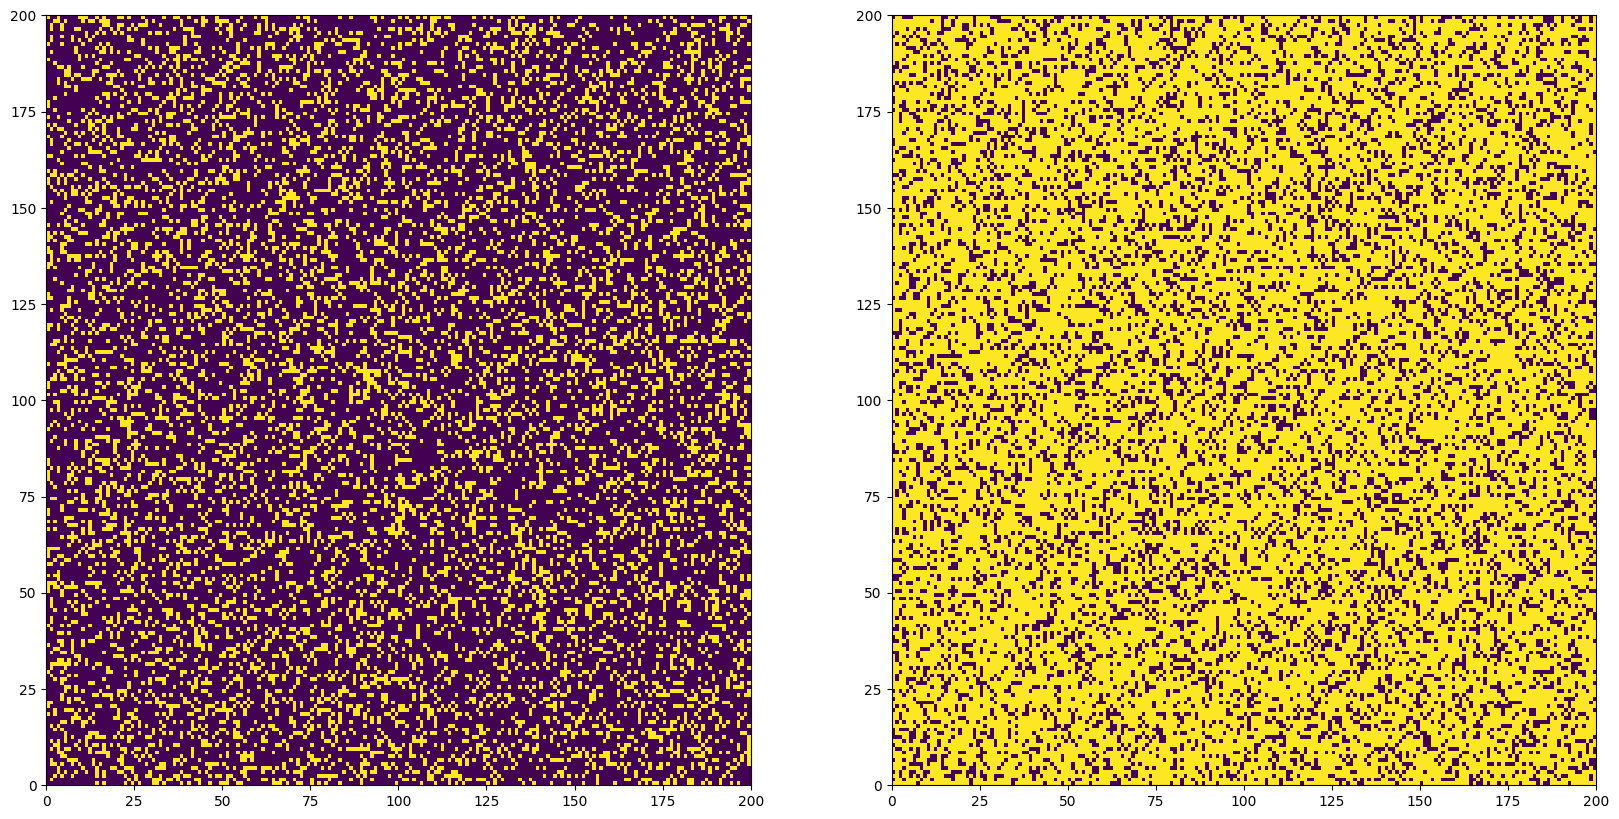

In [7]:
# Generamos el estado inicial de forma aleatoria
N = 200

init_random = torch.rand((N,N)).to(device)
lattice_n = torch.zeros((N, N)).to(device)
lattice_n[init_random>=0.75] = 1
lattice_n[init_random<0.75] = -1

init_random = torch.rand((N,N)).to(device)
lattice_p = torch.zeros((N, N)).to(device)
lattice_p[init_random>=0.25] = 1
lattice_p[init_random<0.25] = -1

# Unimos las dos redes para simular las dos a la vez
lattices = torch.stack([lattice_n, lattice_p]).unsqueeze(dim=1)

plt.figure(figsize=(20,10))
plt.subplot(1,2,1)
plt.pcolormesh(lattice_n.cpu())
plt.subplot(1,2,2)
plt.pcolormesh(lattice_p.cpu())
plt.show()

In [8]:
# Definimos la energía del sistema
def get_energy_arr(lattices):
    # applies the nearest neighbours summation
    kern = generate_binary_structure(2, 1)
    kern[1][1] = False
    kern = torch.tensor(kern.astype(np.float32)).unsqueeze(dim=0).unsqueeze(dim=0).to(device)
    arr = -lattices * conv2d(lattices, kern, padding='same')
    return arr

def get_energy(lattices):
    # applies the nearest neighbours summation
    return get_energy_arr(lattices).sum(axis=(1,2,3))

def get_dE_arr(lattices):
    return -2*get_energy_arr(lattices)

In [9]:
# Definimos el algoritmo de metrópolis
def metropolis(spin_tensor_batch, times, BJs):
    energies = []
    avg_spins = []
    spin_tensor_batch = torch.clone(spin_tensor_batch)
    BJs = BJs.reshape([-1,1,1,1])
    for t in range(times):
        i = np.random.randint(0,2)
        j = np.random.randint(0,2)
        dE = get_dE_arr(spin_tensor_batch)[:,:,i::2,j::2]
        change = (dE>=0)*(torch.rand(dE.shape).to(device) < torch.exp(-BJs*dE)) + (dE<0)
        spin_tensor_batch[:,:,i::2,j::2][change] *=-1
        energies.append(get_energy(spin_tensor_batch))
        avg_spins.append(spin_tensor_batch.sum(axis=(1,2,3))/N**2)
    return torch.vstack(avg_spins), torch.vstack(energies)


In [10]:
# Resolvemos para obtener los spines y la energía.
BJs = 0.5*torch.ones(lattices.shape[0]).to(device)
spins, energies = metropolis(lattices, 1000, BJs)

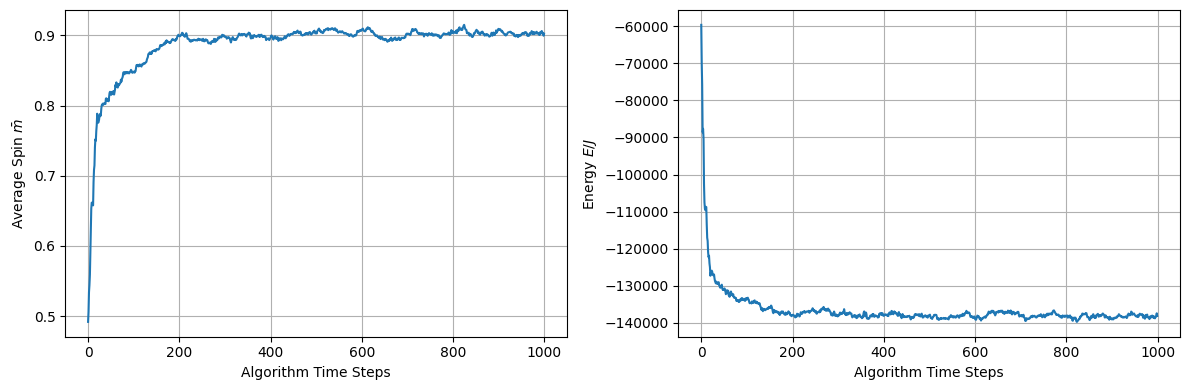

In [11]:
# Representamos La media del spin en cada iteración
fig, axes = plt.subplots(1, 2, figsize=(12,4))
ax = axes[0]
ax.plot(spins[:,1].cpu())
ax.set_xlabel('Algorithm Time Steps')
ax.set_ylabel(r'Average Spin $\bar{m}$')
ax.grid()
ax = axes[1]
ax.plot(energies[:,1].cpu())
ax.set_xlabel('Algorithm Time Steps')
ax.set_ylabel(r'Energy $E/J$')
ax.grid()
fig.tight_layout()
plt.show()

In [16]:
# Ahora vamos a obtener la magnetización y la energía en función de la temperatura
# Tomando m como función de la temperatura T = 1/kB = J/(BJ)k

def get_spin_energy(lattice, BJs):
    lattices = lattice.unsqueeze(dim=0).repeat(len(BJs),1,1,1)
    spins, energies = metropolis(lattices, 1000, BJs)
    spins_avg = torch.mean(spins[-400:], axis=0)
    energies_avg = torch.mean(energies[-400:], axis=0)
    energies_std = torch.std(energies[-400:], axis=0)
    return spins_avg, energies_avg, energies_std

BJs = 1/torch.linspace(1, 3, 20).to(device)
spins_avg_n, E_means_n, E_stds_n = get_spin_energy(lattice_n, BJs)
spins_avg_p, E_means_p, E_stds_p = get_spin_energy(lattice_p, BJs)

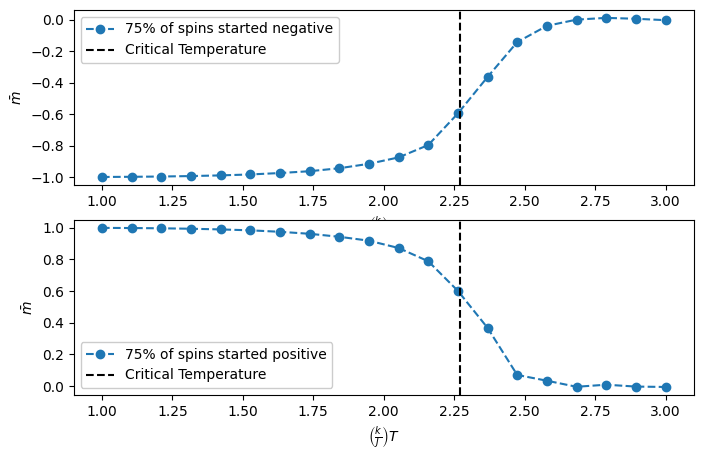

In [17]:
# Representamos los resultados
plt.figure(figsize=(8,5))
plt.subplot(2,1,1)
plt.plot(1/BJs.cpu(), spins_avg_n.cpu(), 'o--', label='75% of spins started negative')
plt.axvline(2.269, color='k', linestyle='--', label='Critical Temperature')
plt.xlabel(r'$\left(\frac{k}{J}\right)T$')
plt.ylabel(r'$\bar{m}$')
plt.legend(facecolor='white', framealpha=1)
plt.subplot(2,1,2)
plt.plot(1/BJs.cpu(), spins_avg_p.cpu(), 'o--', label='75% of spins started positive')
plt.axvline(2.269, color='k', linestyle='--', label='Critical Temperature')
plt.xlabel(r'$\left(\frac{k}{J}\right)T$')
plt.ylabel(r'$\bar{m}$')
plt.legend(facecolor='white', framealpha=1)
plt.show()

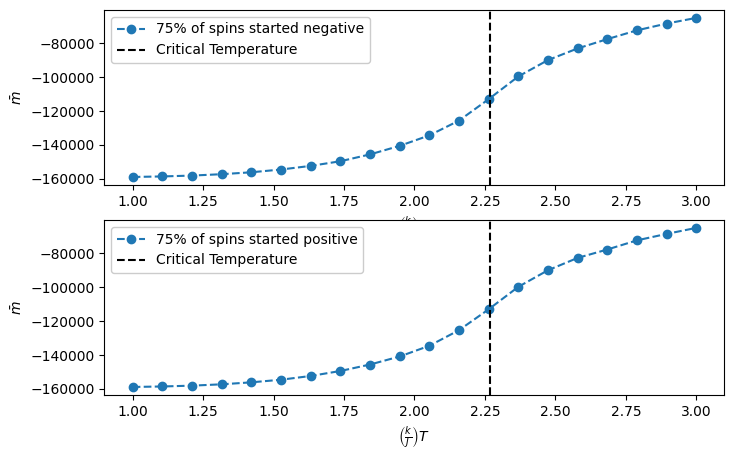

In [18]:
plt.figure(figsize=(8,5))
plt.subplot(2,1,1)
plt.plot(1/BJs.cpu(), E_means_n.cpu(), 'o--', label='75% of spins started negative')
plt.axvline(2.269, color='k', linestyle='--', label='Critical Temperature')
plt.xlabel(r'$\left(\frac{k}{J}\right)T$')
plt.ylabel(r'$\bar{m}$')
plt.legend(facecolor='white', framealpha=1)
plt.subplot(2,1,2)
plt.plot(1/BJs.cpu(), E_means_p.cpu(), 'o--', label='75% of spins started positive')
plt.axvline(2.269, color='k', linestyle='--', label='Critical Temperature')
plt.xlabel(r'$\left(\frac{k}{J}\right)T$')
plt.ylabel(r'$\bar{m}$')
plt.legend(facecolor='white', framealpha=1)
plt.show()

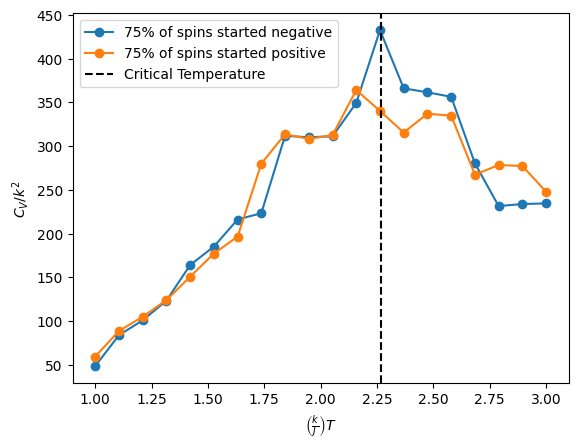

In [19]:
plt.plot(1/BJs.cpu(), E_stds_n.cpu()*BJs.cpu(), '-o',label='75% of spins started negative')
plt.plot(1/BJs.cpu(), E_stds_p.cpu()*BJs.cpu(), '-o', label='75% of spins started positive')
plt.axvline(2.269, color='k', linestyle='--', label='Critical Temperature')
plt.xlabel(r'$\left(\frac{k}{J}\right)T$')
plt.ylabel(r'$C_V / k^2$')
plt.legend()
plt.show()

# Ising 3D:

In [ ]:
N = 150
init_random = torch.rand((N,N,N)).to(device)
lattice_p = torch.zeros((N,N,N)).to(device)
lattice_p[init_random>=0.25] = 1
lattice_p[init_random<0.25] = -1

lattices = torch.stack([lattice_p, lattice_p]).unsqueeze(dim=1)

In [ ]:
def get_energy_arr(lattice):
    # applies the nearest neighbours summation
    kern = generate_binary_structure(3, 1)
    kern[1][1][1] = False
    kern = torch.tensor(kern.astype(np.float32)).unsqueeze(dim=0).unsqueeze(dim=0).to(device)
    arr = -lattice * conv3d(lattice, kern, padding='same')
    return arr

def get_energy(lattice):
    # applies the nearest neighbours summation
    return get_energy_arr(lattice).sum(axis=(2,3,4)).squeeze()

def get_dE_arr(lattice):
    return -2*get_energy_arr(lattice)

In [ ]:
def metropolis(spin_tensor_batch, times, BJs):
    energies = []
    avg_spins = []
    spin_tensor_batch = torch.clone(spin_tensor_batch)
    BJs = BJs.reshape([-1,1,1,1,1])
    for t in range(times):
        i = np.random.randint(0,2)
        j = np.random.randint(0,2)
        k = np.random.randint(0,2)
        dE = get_dE_arr(spin_tensor_batch)[:,:,i::2,j::2,k::2]
        change = (dE>=0)*(torch.rand(dE.shape).to(device) < torch.exp(-BJs*dE)) + (dE<0)
        spin_tensor_batch[:,:,i::2,j::2,k::2][change] *=-1
        energies.append(get_energy(spin_tensor_batch))
        avg_spins.append(spin_tensor_batch.sum(axis=(1,2,3,4))/N**3)
    return torch.vstack(avg_spins), torch.vstack(energies)

In [ ]:
def get_spin_energy(lattice, BJs):
    lattices = lattice.unsqueeze(dim=0).repeat(len(BJs),1,1,1,1)
    spins, energies = metropolis(lattices, 1000, BJs)
    spins_avg = torch.mean(spins[-400:], axis=0)
    energies_avg = torch.mean(energies[-400:], axis=0)
    energies_std = torch.std(energies[-400:], axis=0)
    return spins_avg, energies_avg, energies_std

In [ ]:
BJs = 1/torch.linspace(3, 5.5, 20).to(device)
spins_avg_p, E_means_p, E_stds_p = get_spin_energy(lattice_p, BJs)

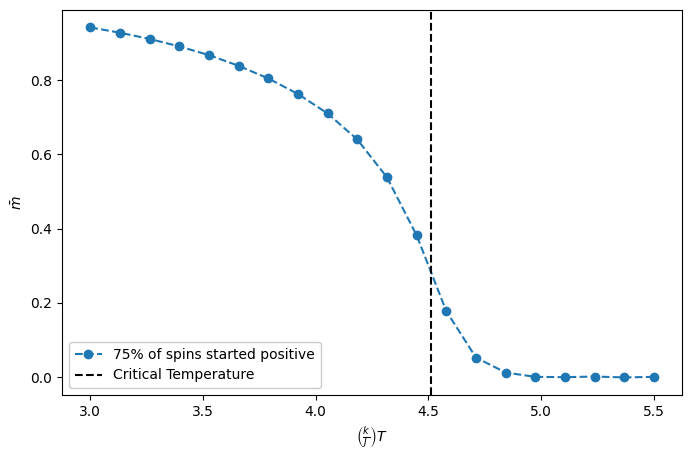

In [ ]:
plt.figure(figsize=(8,5))
plt.plot(1/BJs.cpu(), spins_avg_p.cpu(), 'o--', label='75% of spins started positive')
plt.axvline(1 / 0.221654626, color='k', ls='--', label='Critical Temperature')
plt.xlabel(r'$\left(\frac{k}{J}\right)T$')
plt.ylabel(r'$\bar{m}$')
plt.legend(facecolor='white', framealpha=1)
plt.show()

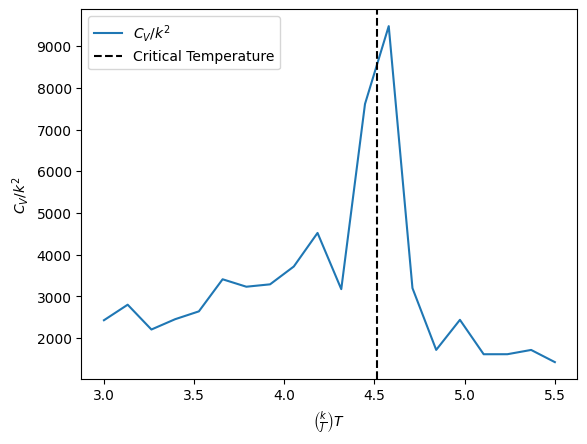

In [ ]:
plt.plot(1/BJs.cpu(), E_stds_p.cpu()*BJs.cpu(), label=r'$C_V / k^2$')
plt.axvline(1 / 0.221654626, color='k', ls='--', label='Critical Temperature')
plt.xlabel(r'$\left(\frac{k}{J}\right)T$')
plt.ylabel(r'$C_V / k^2$')
plt.legend()
plt.show()